# KimiaNet on Kather et al. (2016) CRC Textures


This notebook fine-tunes **KimiaNet** (DenseNet‑121 backbone) to classify the 8 colorectal histology texture classes from **Kather et al., Scientific Reports (2016)**.

**Dataset:** *Collection of textures in colorectal cancer histology* (DOI: 10.5281/zenodo.53169).  
**Classes (8):** tumor epithelium, simple stroma, complex stroma, immune cells, debris, normal mucosal glands, adipose, background.



## 0. Configuration & Imports

In [1]:

import os, glob, random 
from dataclasses import dataclass
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt


# Paths
BASE_DIR = os.path.abspath("./kather_kimianet_workspace")
if not os.path.exists(BASE_DIR):
    os.makedirs(BASE_DIR)
DATA_DIR = os.path.join(BASE_DIR, "data")
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
RAW_DIR  = os.path.join(DATA_DIR, "raw")
if not os.path.exists(RAW_DIR):
    os.makedirs(RAW_DIR)
IMG_DIR  = os.path.join(DATA_DIR, "Kather_texture_2016_image_tiles_5000")
if not os.path.exists(IMG_DIR):
    os.makedirs(IMG_DIR)
LARGE_DIR= os.path.join(DATA_DIR, "Kather_texture_2016_larger_images_10")
if not os.path.exists(LARGE_DIR):
    os.makedirs(LARGE_DIR)
WEIGHTS_DIR = os.path.join(BASE_DIR, "weights")    
if not os.path.exists(WEIGHTS_DIR):
    os.makedirs(WEIGHTS_DIR)
KIMIANET_WEIGHTS_PATH = os.path.join(WEIGHTS_DIR, "KimiaNetKerasWeights.h5")  



# Training config
IMG_SIZE = 224  # DenseNet-121 default; original tiles are 150x150 and need to be resized
NUM_CLASSES = 8
SEED = 42
BATCH_SIZE = 64
EPOCHS_WARMUP = 5
EPOCHS_FINETUNE = 15
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15


tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


## 1. Download dataset

In [27]:

import urllib.request
import os
import zipfile

ZENODO_BASE = "https://zenodo.org/records/53169/files"
TILES_ZIP = "Kather_texture_2016_image_tiles_5000.zip"
LARGE_ZIP = "Kather_texture_2016_larger_images_10.zip"

# Only download if not in folder
def maybe_download(url, dst):
    if os.path.exists(dst):
        print("Exists:", dst)
        return
    print("Downloading:", url)
    urllib.request.urlretrieve(url, dst)
    print("Saved to:", dst)


def maybe_unzip(zip_path, dst_dir):
    if not os.path.exists(zip_path):
        print("Zip not found:", zip_path)
        return

    # Create destination directory if it doesn't exist
    os.makedirs(dst_dir, exist_ok=True)

    # Extract all files from the zip archive
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(dst_dir)

    print("Extracted to:", dst_dir)

tiles_zip_path = os.path.join(RAW_DIR, TILES_ZIP)
large_zip_path = os.path.join(RAW_DIR, LARGE_ZIP)

try:
    maybe_download(f"{ZENODO_BASE}/{TILES_ZIP}", tiles_zip_path)
    maybe_download(f"{ZENODO_BASE}/{LARGE_ZIP}", large_zip_path)
    maybe_unzip(tiles_zip_path, DATA_DIR)
    maybe_unzip(large_zip_path, DATA_DIR)
except Exception as e:
    print("Download skipped or failed:", e)


Downloading: https://zenodo.org/records/53169/files/Kather_texture_2016_image_tiles_5000.zip
Saved to: c:\Users\Giuseppe\Documents\GitHub\Capstone\kather_kimianet_workspace\data\raw\Kather_texture_2016_image_tiles_5000.zip
Downloading: https://zenodo.org/records/53169/files/Kather_texture_2016_larger_images_10.zip
Saved to: c:\Users\Giuseppe\Documents\GitHub\Capstone\kather_kimianet_workspace\data\raw\Kather_texture_2016_larger_images_10.zip
Extracted to: c:\Users\Giuseppe\Documents\GitHub\Capstone\kather_kimianet_workspace\data
Extracted to: c:\Users\Giuseppe\Documents\GitHub\Capstone\kather_kimianet_workspace\data


## 2. Verify dataset layout & class names

In [28]:

# The IMG_DIR should have folders for each tissue type
expected_classes = [
    '01_TUMOR', '02_STROMA', '03_COMPLEX', '04_LYMPHO', '05_DEBRIS', '06_MUCOSA', '07_ADIPOSE', '08_EMPTY'
]

if not os.path.isdir(IMG_DIR):
    raise FileNotFoundError(f"Couldn't find the tiles folder: {IMG_DIR}")

classes = sorted([d for d in os.listdir(IMG_DIR) if os.path.isdir(os.path.join(IMG_DIR,d))])
print("Found classes:", classes)

# Check if we have all the classes we expect
missing = [c for c in expected_classes if c not in classes]
if missing:
    print("Some expected classes not found:", missing)
    
# Count images per class
for c in classes:
    cnt = len(glob.glob(os.path.join(IMG_DIR, c, "*.png"))) + len(glob.glob(os.path.join(IMG_DIR, c, "*.tif"))) + len(glob.glob(os.path.join(IMG_DIR, c, "*.jpg")))
    print(f"{c:20s}: {cnt}")


Found classes: ['01_TUMOR', '02_STROMA', '03_COMPLEX', '04_LYMPHO', '05_DEBRIS', '06_MUCOSA', '07_ADIPOSE', '08_EMPTY']
01_TUMOR            : 625
02_STROMA           : 625
03_COMPLEX          : 625
04_LYMPHO           : 625
05_DEBRIS           : 625
06_MUCOSA           : 625
07_ADIPOSE          : 625
08_EMPTY            : 625


## 3. Train/Val/Test split (stratified by class)

In [29]:

from collections import defaultdict

def stratified_split(image_root, val_split=0.15, test_split=0.15, seed=SEED):
    rng = random.Random(seed)
    class_to_paths = defaultdict(list)
    for c in sorted(os.listdir(image_root)):
        cdir = os.path.join(image_root, c)
        if not os.path.isdir(cdir): 
            continue
        files = []
        for ext in ("*.png","*.jpg","*.jpeg","*.tif","*.tiff","*.bmp"):
            files.extend(glob.glob(os.path.join(cdir, ext)))
        files = sorted(files)
        rng.shuffle(files)
        class_to_paths[c] = files
    
    train, val, test = [], [], []
    for c, paths in class_to_paths.items():
        n = len(paths)
        n_test = int(round(n * test_split))
        n_val  = int(round(n * val_split))
        test.extend([(p, c) for p in paths[:n_test]])
        val.extend([(p, c) for p in paths[n_test:n_test+n_val]])
        train.extend([(p, c) for p in paths[n_test+n_val:]])
    return train, val, test

train_samples, val_samples, test_samples = stratified_split(IMG_DIR, VAL_SPLIT, TEST_SPLIT, SEED)
print(len(train_samples), len(val_samples), len(test_samples))



3496 752 752


## 4. tf.data pipelines (+ augmentations)

In [43]:

AUTOTUNE = tf.data.AUTOTUNE
class_names = sorted(list({c for _, c in train_samples}))
class_to_idx = {c:i for i,c in enumerate(class_names)}
print("Class mapping:", class_to_idx)

from PIL import Image
import numpy as np
import tensorflow as tf

def _pil_read(path):
    # Convert tensor to string and decode bytes to string
    path_str = path.numpy().decode('utf-8')
    with Image.open(path_str) as im:
        arr = np.array(im, dtype=np.uint8)
    return arr

def decode_img(path):
    img = tf.py_function(func=_pil_read, inp=[path], Tout=tf.uint8)
    img.set_shape([None, None, 3])
    return img

def preprocess(path, label):
    img = decode_img(path)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE), antialias=True)
    img = tf.cast(img, tf.float32) / 255.0
    return img, tf.cast(label, tf.int32)



def augment(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    # 90-degree rotations (k in {0,1,2,3})
    k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
    img = tf.image.rot90(img, k)
    # light color jitter
    img = tf.image.random_brightness(img, max_delta=0.02)
    img = tf.image.random_contrast(img, lower=0.95, upper=1.05)
    return img, label

def make_ds(samples, training=False, batch_size=BATCH_SIZE):
    paths = [p for p,_ in samples]
    labels = [class_to_idx[c] for _,c in samples]
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(buffer_size=len(paths), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(preprocess, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds
train_ds_path = os.path.join(DATA_DIR, "Train_ds")
val_ds_path = os.path.join(DATA_DIR, "Val_ds")
test_ds_path = os.path.join(DATA_DIR, "Test_ds")

if os.path.exists(train_ds_path) and os.path.exists(val_ds_path) and os.path.exists(test_ds_path):
    train_ds = tf.data.Dataset.load(train_ds_path)
    val_ds = tf.data.Dataset.load(val_ds_path)
    test_ds = tf.data.Dataset.load(test_ds_path)
else:
    train_ds = make_ds(train_samples, training=True)
    val_ds = make_ds(val_samples, training=False)
    test_ds = make_ds(test_samples, training=False)
    train_ds.save(train_ds_path)
    val_ds.save(val_ds_path)
    test_ds.save(test_ds_path)
for imgs, labs in train_ds.take(1):
    print("Batch:", imgs.shape, labs.shape)


Class mapping: {'01_TUMOR': 0, '02_STROMA': 1, '03_COMPLEX': 2, '04_LYMPHO': 3, '05_DEBRIS': 4, '06_MUCOSA': 5, '07_ADIPOSE': 6, '08_EMPTY': 7}
Batch: (64, 224, 224, 3) (64,)


## 5. Build model (KimiaNet → 8‑class head)

In [8]:

# DenseNet-121 backbone

backbone = keras.applications.DenseNet121(include_top=False, weights=None, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Try to load KimiaNet weights
if not os.path.isfile(KIMIANET_WEIGHTS_PATH):
    print(f"KimiaNet weights not found at {KIMIANET_WEIGHTS_PATH}, attempting to download...")
    try:
        import urllib.request
        keras_weights_url = "https://github.com/KimiaLabMayo/KimiaNet/raw/refs/heads/main/KimiaNet_Weights/weights/KimiaNetKerasWeights.h5"
        pytorch_weights_url = "https://github.com/KimiaLabMayo/KimiaNet/raw/refs/heads/main/KimiaNet_Weights/weights/KimiaNetPyTorchWeights.pth"

        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(KIMIANET_WEIGHTS_PATH), exist_ok=True)

        # Download Keras weights
        print(f"Downloading Keras weights from {keras_weights_url}")
        urllib.request.urlretrieve(keras_weights_url, KIMIANET_WEIGHTS_PATH)
        print(f"Downloaded KimiaNet weights to {KIMIANET_WEIGHTS_PATH}")
    except Exception as e:
        print(f"Failed to download KimiaNet weights: {e}")

if os.path.isfile(KIMIANET_WEIGHTS_PATH):
    try:
        print("Loading KimiaNet weights from:", KIMIANET_WEIGHTS_PATH)
        backbone.load_weights(KIMIANET_WEIGHTS_PATH, by_name=True, skip_mismatch=True)
        print("KimiaNet weights loaded (by_name, skip_mismatch)." )
    except Exception as e:
        print("Failed to load KimiaNet weights:", e)

x = layers.GlobalAveragePooling2D()(backbone.output)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
out = layers.Dense(len(class_names), activation='softmax')(x)
model = keras.Model(inputs=backbone.input, outputs=out)

# Phase A: warm-up — freeze backbone
for l in backbone.layers:
    l.trainable = False

model.compile(
    optimizer=optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


KimiaNet weights not found at c:\Users\Giuseppe\Documents\GitHub\Capstone\kather_kimianet_workspace\weights\KimiaNetKerasWeights.h5, attempting to download...
Downloaded KimiaNet weights to c:\Users\Giuseppe\Documents\GitHub\Capstone\kather_kimianet_workspace\weights\KimiaNetKerasWeights.h5
Loading KimiaNet weights from: c:\Users\Giuseppe\Documents\GitHub\Capstone\kather_kimianet_workspace\weights\KimiaNetKerasWeights.h5
KimiaNet weights loaded (by_name, skip_mismatch).


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,049,800 (26.89 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 7,039,552 (26.85 MB)

## 6. Train — Phase A (head only)

In [ ]:

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]
hist_a = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_WARMUP, callbacks=callbacks)



Epoch 1/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 59s 998ms/step - accuracy: 0.6101 - loss: 0.9949 - val_accuracy: 0.4880 - val_loss: 1.3374
Epoch 2/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 53s 964ms/step - accuracy: 0.7220 - loss: 0.7079 - val_accuracy: 0.6729 - val_loss: 0.8599
Epoch 3/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 53s 964ms/step - accuracy: 0.7523 - loss: 0.6367 - val_accuracy: 0.6755 - val_loss: 0.7622
Epoch 4/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 53s 961ms/step - accuracy: 0.7729 - loss: 0.6220 - val_accuracy: 0.7739 - val_loss: 0.6518
Epoch 5/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 53s 959ms/step - accuracy: 0.7732 - loss: 0.5963 - val_accuracy: 0.7686 - val_loss: 0.6476


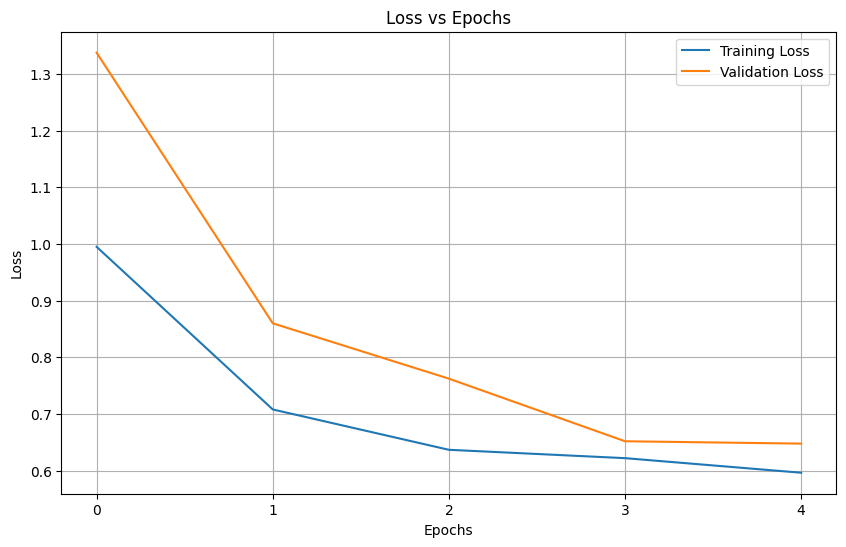

In [35]:
import matplotlib.pyplot as plt
def plot_loss_vs_epochs(history):
    """
    Plot the training and validation loss vs epochs

    Parameters:
    -----------
    history : History object
        The history object returned by model.fit()
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.xticks(range(len(history.history['loss'])))
    plt.show()

plot_loss_vs_epochs(hist_a)



## 7. Train — Phase B (gradual unfreeze last dense block)

In [10]:

# Unfreeze specific layers in the backbone for fine-tuning
# We want to train only the deeper layers that contain more specialized features
unfreeze = False
for l in backbone.layers:
    name = l.name.lower()
    # Look for the last dense block (block 4) or conv5 layers in DenseNet-121
    # These are the deeper layers that capture more complex, domain-specific features
    if ('conv5' in name) or ('dense_block4' in name) or ('bn' in name and 'conv5' in name):
        unfreeze = True
    if unfreeze:
        l.trainable = True  # Make these layers trainable

# Re-compile the model with a smaller learning rate for fine-tuning
# Lower learning rate helps make subtle adjustments without destroying pre-trained weights
model.compile(
    optimizer=optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
hist_b = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_FINETUNE, callbacks=callbacks)


Epoch 1/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.7574 - loss: 0.6769 - val_accuracy: 0.6436 - val_loss: 0.8824
Epoch 2/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.8275 - loss: 0.4935 - val_accuracy: 0.6676 - val_loss: 0.8302
Epoch 3/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.8341 - loss: 0.4567 - val_accuracy: 0.7340 - val_loss: 0.6299
Epoch 4/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.8484 - loss: 0.4118 - val_accuracy: 0.8551 - val_loss: 0.4464
Epoch 5/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.8535 - loss: 0.4057 - val_accuracy: 0.8630 - val_loss: 0.3889
Epoch 6/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.8576 - loss: 0.3822 - val_accuracy: 0.8737 - val_loss: 0.3504
Epoch 7/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.8661 - loss: 0.3578 - val_accuracy: 0.8723 - val_loss: 0.3505
Epoch 8/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.8764 - loss: 0.3428 - val_accuracy: 0.8816 - val_loss:

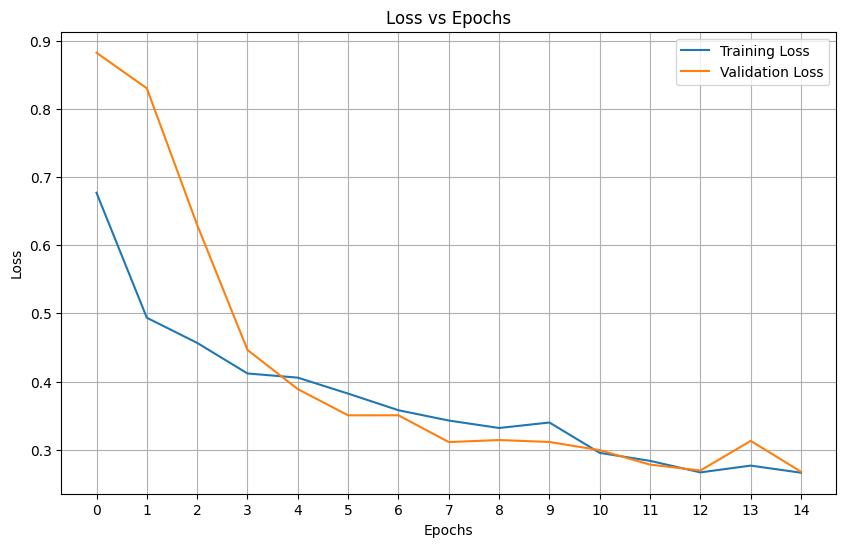

In [37]:
plot_loss_vs_epochs(hist_b)


## 8. Evaluation — metrics & confusion matrix

              precision    recall  f1-score   support

    01_TUMOR     0.9667    0.9255    0.9457        94
   02_STROMA     0.9487    0.7872    0.8605        94
  03_COMPLEX     0.7982    0.9255    0.8571        94
   04_LYMPHO     0.9765    0.8830    0.9274        94
   05_DEBRIS     0.9167    0.9362    0.9263        94
   06_MUCOSA     0.9020    0.9787    0.9388        94
  07_ADIPOSE     0.9444    0.9043    0.9239        94
    08_EMPTY     0.9118    0.9894    0.9490        94

    accuracy                         0.9162       752
   macro avg     0.9206    0.9162    0.9161       752
weighted avg     0.9206    0.9162    0.9161       752



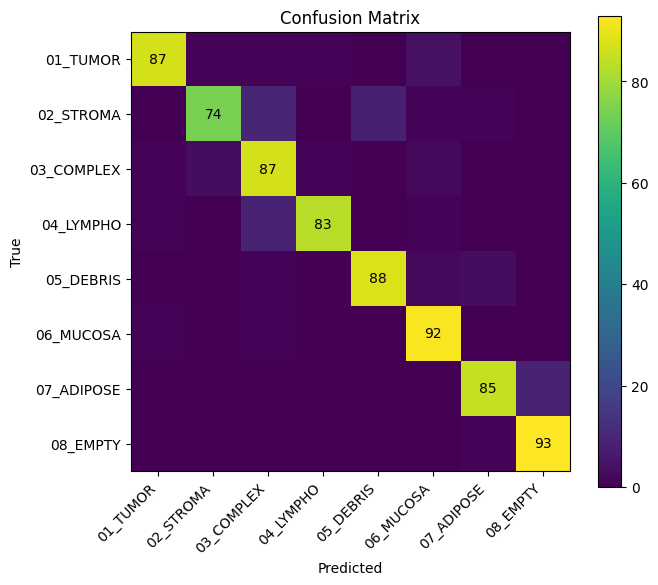

In [15]:

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Collect predictions
y_true = []
y_pred = []
for imgs, labs in test_ds:
    preds = model.predict(imgs, verbose=0)
    y_true.extend(labs.numpy().tolist())
    y_pred.extend(np.argmax(preds, axis=1).tolist())

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
fig = plt.figure(figsize=(7,6))
im = plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha='right')
plt.yticks(tick_marks, class_names)

# Add text annotations to the heatmap
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if cm[i, j] >= thresh:
            plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                     color="black")


plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()



## 10. Save model & class mapping

In [12]:
import json
SAVE_DIR = os.path.join(BASE_DIR, 'artifacts')
os.makedirs(SAVE_DIR, exist_ok=True)

# Save Keras model
model_path = os.path.join(SAVE_DIR, 'kimianet_kather_classifier.keras')
model.save(model_path)
print('Saved model to:', model_path)

# Save class mapping
with open(os.path.join(SAVE_DIR, 'class_to_idx.json'), 'w') as f:
    json.dump(class_to_idx, f, indent=2)
print('Saved class mapping.')


Saved model to: c:\Users\Giuseppe\Documents\GitHub\Capstone\kather_kimianet_workspace\artifacts\kimianet_kather_classifier.keras
Saved class mapping.


In [5]:
SAVE_DIR = os.path.join(BASE_DIR, 'artifacts')
model_path = os.path.join(SAVE_DIR, 'kimianet_kather_classifier.keras')

model = tf.keras.models.load_model(model_path)



Model found at: kather_kimianet_workspace/artifacts/kimianet_kather_classifier.keras
Class mapping found at: kather_kimianet_workspace/artifacts/class_to_idx.json

Loading model...
Model loaded successfully!

Available classes: ['01_TUMOR', '02_STROMA', '03_COMPLEX', '04_LYMPHO', '05_DEBRIS', '06_MUCOSA', '07_ADIPOSE', '08_EMPTY']


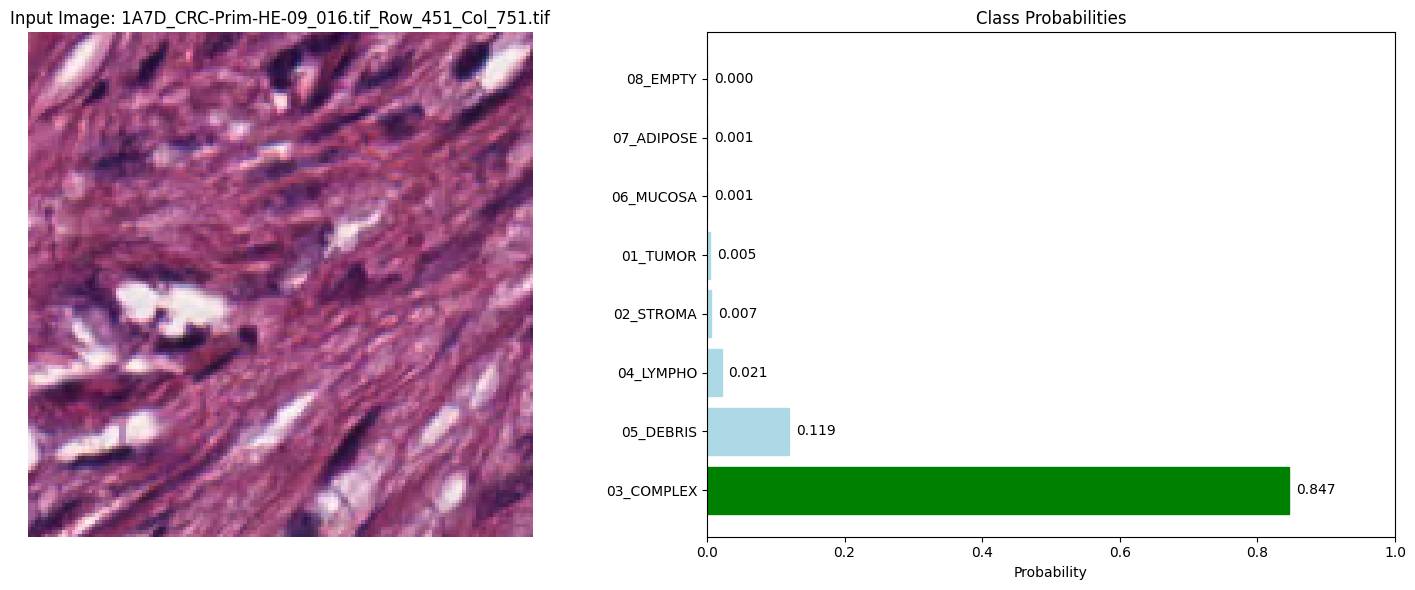

Predicted Class: 03_COMPLEX
Confidence: 0.8466 (84.66%)


In [ ]:

import os
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import display, Image as IPImage
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual


# ## Define Helper Functions

def load_model_and_classes(model_path, class_mapping_path):
    """
    Load the trained model and class mapping.
    
    Parameters
    ----------
    model_path : str
        Path to the saved Keras model
    class_mapping_path : str
        Path to the JSON file containing class-to-index mapping
        
    Returns
    -------
    model : keras.Model
        The loaded Keras model
    idx_to_class : dict
        Dictionary mapping indices to class names
    """
    # Load model
    model = keras.models.load_model(model_path)
    
    # Load class mapping
    with open(class_mapping_path, 'r') as f:
        class_to_idx = json.load(f)
    
    # Create reverse mapping
    idx_to_class = {idx: class_name for class_name, idx in class_to_idx.items()}
    
    return model, idx_to_class


def preprocess_image(image_path, img_size=224):
    """
    Preprocess a single image for prediction.
    
    Parameters
    ----------
    image_path : str
        Path to the image file
    img_size : int
        Target size for the image (default: 224)
        
    Returns
    -------
    img_array : np.ndarray
        Preprocessed image array ready for prediction
    """
    # Open and convert image
    with Image.open(image_path) as img:
        # Convert to RGB if necessary
        if img.mode != 'RGB':
            img = img.convert('RGB')
        
        # Resize image
        img = img.resize((img_size, img_size), Image.Resampling.LANCZOS)
        
        # Convert to numpy array
        img_array = np.array(img, dtype=np.float32)
        
        # Normalize to [0, 1]
        img_array = img_array / 255.0
        
        # Add batch dimension
        img_array = np.expand_dims(img_array, axis=0)
        
    return img_array


def predict_image(model, image_path, idx_to_class, img_size=224):
    """
    Predict the class of a single image.
    
    Parameters
    ----------
    model : keras.Model
        The trained model
    image_path : str
        Path to the image file
    idx_to_class : dict
        Dictionary mapping indices to class names
    img_size : int
        Target size for the image (default: 224)
        
    Returns
    -------
    predicted_class : str
        The predicted class name
    confidence : float
        The confidence score for the prediction
    all_probs : dict
        Dictionary with probabilities for all classes
    """
    # Preprocess image
    img_array = preprocess_image(image_path, img_size)
    
    # Make prediction
    predictions = model.predict(img_array, verbose=0)
    
    # Get predicted class
    predicted_idx = np.argmax(predictions[0])
    predicted_class = idx_to_class[predicted_idx]
    confidence = predictions[0][predicted_idx]
    
    # Get all probabilities
    all_probs = {idx_to_class[i]: float(predictions[0][i]) 
                 for i in range(len(predictions[0]))}
    
    return predicted_class, confidence, all_probs


def visualize_prediction(image_path, predicted_class, confidence, all_probs, show_all_probs=True):
    """
    Visualize the prediction results.

    Parameters
    ----------
    image_path : str
        Path to the image file
    predicted_class : str
        The predicted class name
    confidence : float
        The confidence score for the prediction
    all_probs : dict
        Dictionary with probabilities for all classes
    show_all_probs : bool
        Whether to show all class probabilities
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Display image
    img = Image.open(image_path)
    ax1.imshow(img)
    ax1.set_title(f'Input Image: {os.path.basename(image_path)}')
    ax1.axis('off')

    # Display probabilities
    if show_all_probs:
        sorted_probs = sorted(all_probs.items(), key=lambda x: x[1], reverse=True)
        classes = [item[0] for item in sorted_probs]
        probs = [item[1] for item in sorted_probs]

        bars = ax2.barh(classes, probs)

        # Highlight the predicted class
        for i, (class_name, prob) in enumerate(sorted_probs):
            if class_name == predicted_class:
                bars[i].set_color('green')
            else:
                bars[i].set_color('lightblue')

        ax2.set_xlabel('Probability')
        ax2.set_title('Class Probabilities')
        ax2.set_xlim(0, 1)

        # Add probability values on bars
        for i, (class_name, prob) in enumerate(sorted_probs):
            ax2.text(prob + 0.01, i, f'{prob:.3f}', va='center')

    plt.tight_layout()
    plt.show()

    # Print results
    print("="*50)
    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence: {confidence:.4f} ({confidence*100:.2f}%)")
    print("="*50)


# ## Load Model and Class Mapping

# Set default paths
model_path = 'kather_kimianet_workspace/artifacts/kimianet_kather_classifier.keras'
class_mapping_path = 'kather_kimianet_workspace/artifacts/class_to_idx.json'

# Check if files exist
if not os.path.exists(model_path):
    print(f"Warning: Model file not found at {model_path}")
    print("Please update the model_path variable with the correct path.")
else:
    print(f"Model found at: {model_path}")

if not os.path.exists(class_mapping_path):
    print(f"Warning: Class mapping file not found at {class_mapping_path}")
    print("Please update the class_mapping_path variable with the correct path.")
else:
    print(f"Class mapping found at: {class_mapping_path}")


# Load the model and class mapping
try:
    print("\nLoading model...")
    model, idx_to_class = load_model_and_classes(model_path, class_mapping_path)
    print("Model loaded successfully!")
    print(f"\nAvailable classes: {list(idx_to_class.values())}")
except Exception as e:
    print(f"Error loading model: {e}")
    model = None
    idx_to_class = None


# ## Make Predictions on Images


# Specify the path to your TIF image
image_path = os.path.join("kather_kimianet_workspace", "data", "Kather_texture_2016_image_tiles_5000", "03_COMPLEX", "1A7D_CRC-Prim-HE-09_016.tif_Row_451_Col_751.tif")  # Update this with your image path

# Make prediction if model is loaded
if model is not None and os.path.exists(image_path):
    predicted_class, confidence, all_probs = predict_image(model, image_path, idx_to_class)
    visualize_prediction(image_path, predicted_class, confidence, all_probs)
else:
    if model is None:
        print("Model not loaded. Please check the model path.")
    else:
        print(f"Image not found: {image_path}")
        print("Please update the image_path variable with a valid path.")



